In [17]:
import matplotlib.pyplot as plt
import numpy as np

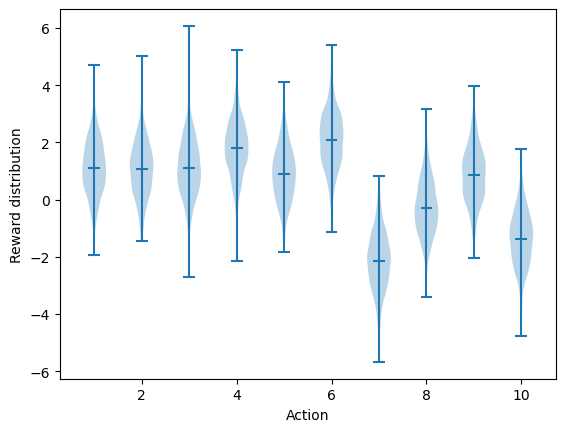

In [18]:
class MultiArmedBanditEnv:
  def __init__(self, k_arms: int = 10):
    self.k_arms = k_arms
    self.action_space = np.arange(k_arms)
    self.reset()
  
  def reset(self):
    self.q_star = np.random.randn(self.k_arms)
    self.best_action = np.argmax(self.q_star)
  
  def step(self, arm: int):
    assert arm in self.action_space
    reward: float = np.random.normal() + self.q_star[arm]
    return reward
  
  def render(self):
    samples = np.random.randn(1000, self.k_arms) + self.q_star
    plt.violinplot(dataset=samples, showmeans=True)
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.show()

bandit_env = MultiArmedBanditEnv()
bandit_env.render()

In [19]:
class AveragingGambler:
  def __init__(self, total_actions: int = 10, epsilon: float = 0):
    self.total_actions = total_actions
    self.epsilon = epsilon
    self.reset()

  def act(self):
    if np.random.random() < self.epsilon:
      return np.random.choice(self.total_actions)
    return np.argmax(self.Q)

  def update(self, action: int, reward: float):
    self.N[action] += 1
    self.Q[action] += (reward - self.Q[action]) / self.N[action]

  def reset(self):
    self.N = np.zeros(self.total_actions)
    self.Q = np.zeros(self.total_actions)

In [20]:
import ray

ray.shutdown()
ray.init()

@ray.remote
def run_episode(bandit: MultiArmedBanditEnv, gambler: AveragingGambler, max_time_steps: int = 1e3):
  rewards = []
  best_action_counts  = []
  bandit.reset()
  gambler.reset()
  for _ in range(max_time_steps):
    action = gambler.act()
    reward = bandit.step(action)
    gambler.update(action, reward)
    rewards.append(reward)
    best_action_counts.append(1 if action == bandit.best_action else 0)
  return rewards, best_action_counts


def simulate(bandit: MultiArmedBanditEnv, gambler: AveragingGambler, num_of_episodes: int = 2e3, max_time_steps: int = 1e3):
  bandit_id = ray.put(bandit)
  gambler_id = ray.put(gambler)
  rewards = np.zeros((num_of_episodes, max_time_steps))
  best_action_counts = np.zeros(rewards.shape)
  episodes = [run_episode.remote(bandit_id, gambler_id, max_time_steps) for _ in range(num_of_episodes)]
  for i, (episode_rewards, episode_best_action_counts) in enumerate(ray.get(episodes)):
    rewards[i,:] = episode_rewards
    best_action_counts[i,:] = episode_best_action_counts
  mean_rewards = rewards.mean(axis=0)
  mean_best_action_counts = best_action_counts.mean(axis=0)
  return mean_rewards, mean_best_action_counts

2022-12-01 01:36:01,911	INFO worker.py:1528 -- Started a local Ray instance.


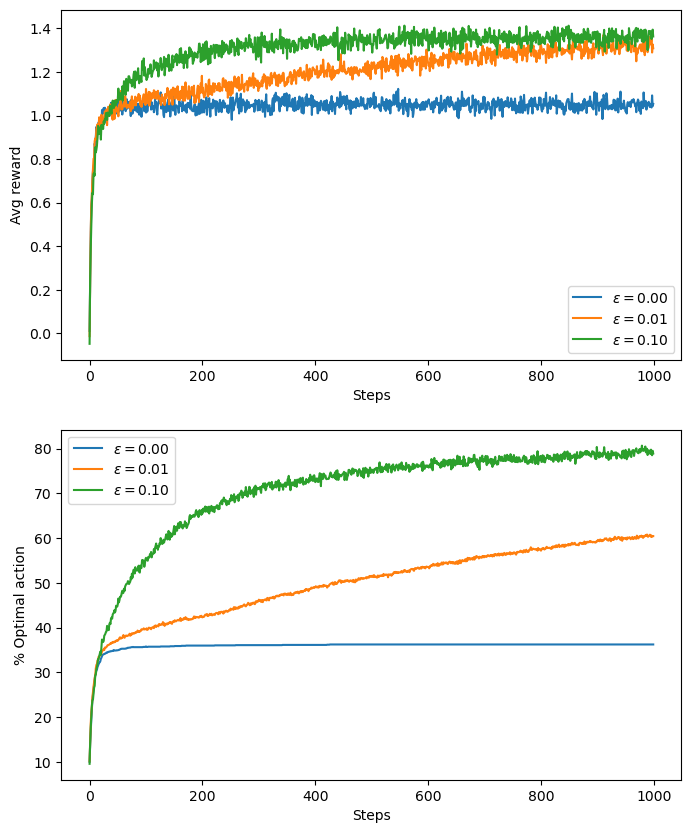

In [22]:
def exercise_2_5():
  fig, (mean_reward_plot, mean_best_action_plot ) = plt.subplots(2, figsize=(8, 10))
  mean_reward_plot.set_xlabel("Steps")
  mean_reward_plot.set_ylabel("Avg reward")
  mean_best_action_plot.set_xlabel("Steps")
  mean_best_action_plot.set_ylabel("% Optimal action")
  for epsilon in [0, 0.01, 0.1]:
    mean_rewards, mean_best_action_counts = simulate(MultiArmedBanditEnv(), AveragingGambler(epsilon=epsilon), num_of_episodes=int(2e3), max_time_steps=int(1e3))
    mean_reward_plot.plot(mean_rewards, label='$\epsilon = %.02f$' % (epsilon))
    mean_best_action_plot.plot(mean_best_action_counts * 100, label='$\epsilon = %.02f$' % (epsilon))
  mean_reward_plot.legend()
  mean_best_action_plot.legend()
  plt.show()

exercise_2_5()